In [1]:
model_path = "model/trained_on_L3_nobias_encoder_decoder_equalspace_l2_001.pt"

In [2]:
from trainer import Trainer
from zytlib import vector, path
from zytlib import Logger
from zytlib.table import table
from zytlib.visual.animation import TimeStamp, ScatterAnimation
from tqdm import tqdm, trange
import argparse
import torch
from torchfunction.device import todevice, get_device
from matplotlib import pyplot as plt
import seaborn as sns
import functools
import numpy as np
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from utils import SOR
from torchfunction.inspect import get_shape
from collections import OrderedDict
import math
%config InlineBackend.figure_format = 'svg'
device = get_device("cuda")

Using GPU device 1...


In [3]:
model = Trainer.load(model_path, map_device=device)

In [4]:
acc_diff_encoder_rank = vector()

for encoder_rank in trange(10, 25):
    model_lowrank = Trainer(decoder_dim=1024, encoder_to_decoder_equal_space=True, encoder_max_rank=encoder_rank, batch_size=64)
    model_lowrank.load_state_dict(model_path)
    
    result = vector()

    hidden_state_all = vector()
    ground_truth_all = vector()
    decoder_hidden_state_all = vector()

    with torch.no_grad():

        for batch in model_lowrank.test_dataloader:
            input_encoder, length, ground_truth_tensor, ground_truth_length, last_delay_length = todevice(batch, device=model_lowrank.hyper["device"])
            hidden_state, final_state = model_lowrank.encoder(input_encoder, length)
            hidden_state_all.append(hidden_state)
            ground_truth_all.append(ground_truth_tensor)
            decoded_seq, decoder_hidden_state = model_lowrank.decoder(final_state, torch.zeros_like(ground_truth_tensor).fill_(-1), ground_truth_length, teaching_forcing_ratio=0.0)
            decoder_hidden_state_all.append(decoder_hidden_state)
            decoded_item = decoded_seq.argmax(-1)
            for i in range(hidden_state.shape[0]):
                result.append(vector(ground_truth_tensor[i, :]==decoded_item[i, :]).map(lambda x: x.cpu().numpy()))
                
    t = result.rmap(int).mean(0)
    acc_diff_encoder_rank.append(t)

  7%|▋         | 1/15 [00:13<03:03, 13.12s/it]

[0.043055555555555555, 0.27098765432098765, 0.16790123456790124]


 13%|█▎        | 2/15 [00:25<02:46, 12.81s/it]

[0.8575617283950617, 0.26651234567901233, 0.18919753086419752]


 20%|██        | 3/15 [00:38<02:32, 12.69s/it]

[0.2111111111111111, 0.22901234567901235, 0.2191358024691358]


 27%|██▋       | 4/15 [00:50<02:18, 12.64s/it]

[0.6151234567901235, 0.28271604938271605, 0.1992283950617284]


 33%|███▎      | 5/15 [01:03<02:06, 12.66s/it]

[0.9290123456790124, 0.31296296296296294, 0.36959876543209874]


 40%|████      | 6/15 [01:16<01:53, 12.65s/it]

[0.8861111111111111, 0.5558641975308642, 0.5600308641975309]


 47%|████▋     | 7/15 [01:29<01:42, 12.87s/it]

[0.9785493827160494, 0.7671296296296296, 0.8441358024691358]


 53%|█████▎    | 8/15 [01:42<01:29, 12.79s/it]

[0.9861111111111112, 0.890895061728395, 0.8925925925925926]


 60%|██████    | 9/15 [01:54<01:16, 12.78s/it]

[0.9853395061728395, 0.9388888888888889, 0.8151234567901234]


 67%|██████▋   | 10/15 [02:07<01:04, 12.85s/it]

[0.9983024691358025, 0.9507716049382716, 0.8873456790123457]


 73%|███████▎  | 11/15 [02:20<00:51, 12.81s/it]

[0.9930555555555556, 0.8712962962962963, 0.8854938271604939]


 80%|████████  | 12/15 [02:33<00:38, 12.88s/it]

[0.9962962962962963, 0.9027777777777778, 0.9628086419753087]


 87%|████████▋ | 13/15 [02:46<00:25, 12.87s/it]

[0.9979938271604938, 0.9228395061728395, 0.975925925925926]


 93%|█████████▎| 14/15 [02:59<00:12, 12.89s/it]

[0.9981481481481481, 0.9851851851851852, 0.9871913580246914]


100%|██████████| 15/15 [03:11<00:00, 12.80s/it]

[0.999537037037037, 0.970679012345679, 0.9660493827160493]


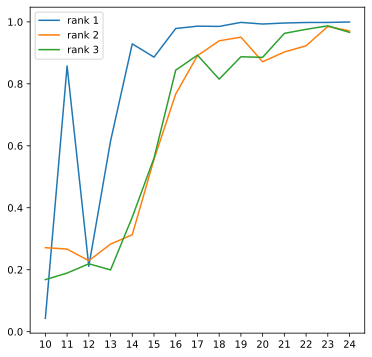

In [8]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(6, 6))

for rank in range(3):
    ax.plot(range(10, 25), acc_diff_encoder_rank[:, rank], label="rank {}".format(rank+1))

plt.legend()
plt.title("test accuracy for different encoder rank")
ax.set_xticks(range(10, 25))

In [9]:
acc_diff_decoder_rank = vector()

for decoder_rank in trange(1, 10):
    model_lowrank = Trainer(decoder_dim=1024, encoder_to_decoder_equal_space=True, decoder_max_rank=decoder_rank, batch_size=64)
    model_lowrank.load_state_dict(model_path)
    
    result = vector()

    hidden_state_all = vector()
    ground_truth_all = vector()
    decoder_hidden_state_all = vector()

    with torch.no_grad():

        for batch in model_lowrank.test_dataloader:
            input_encoder, length, ground_truth_tensor, ground_truth_length, last_delay_length = todevice(batch, device=model_lowrank.hyper["device"])
            hidden_state, final_state = model_lowrank.encoder(input_encoder, length)
            hidden_state_all.append(hidden_state)
            ground_truth_all.append(ground_truth_tensor)
            decoded_seq, decoder_hidden_state = model_lowrank.decoder(final_state, torch.zeros_like(ground_truth_tensor).fill_(-1), ground_truth_length, teaching_forcing_ratio=0.0)
            decoder_hidden_state_all.append(decoder_hidden_state)
            decoded_item = decoded_seq.argmax(-1)
            for i in range(hidden_state.shape[0]):
                result.append(vector(ground_truth_tensor[i, :]==decoded_item[i, :]).map(lambda x: x.cpu().numpy()))
                
    t = result.rmap(int).mean(0)
    acc_diff_decoder_rank.append(t)

100%|██████████| 9/9 [01:53<00:00, 12.60s/it]


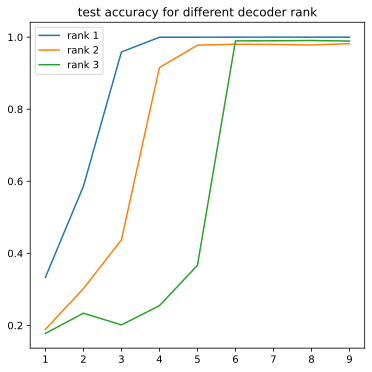

In [10]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(6, 6))

for rank in range(3):
    ax.plot(range(1, 10), acc_diff_decoder_rank[:, rank], label="rank {}".format(rank+1))

plt.legend()
plt.title("test accuracy for different decoder rank")
ax.set_xticks(range(1, 10))